# Measurement on energy conservation in Compton effect
>for varying angles in 15 $^\circ$ steps
>
>sample: $^{137}$Cs

In [54]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./data_npy/"


In [399]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    if c.s == 0 :
        print("You are stupid!")
        raise("error is stupid")
    digit = -int(np.floor(np.log10(np.abs(c.s))))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def ucarray(X):
    return un.uarray([i.n for i in X],[i.s for i in X])

nom = un.nominal_values
sam = un.std_devs
    


In [52]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [35]:
# %load "../../preamb.py"
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys

npy_dir = "./data_npy/"


## Functions

In [339]:
def linear(x, a, b):
    return (a*x + b)

def gauss0(x, *p):
    A, mu, sigma = p
    return  A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

def gauss(x, *p):
    A, mu, sigma, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) + offset

def gauss_times_exp(x, *p):
    A, mu, sigma, C, lamb, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) * \
            C * np.exp(lamb * (x - x_min)) + \
            offset
        
import scipy as sc
norm = sc.stats.norm

# PS scintillator

## $^{137}$Cs Sample at various angles, PS (electrons)

## Background and random coincidences

In [112]:
#### Background ####
file_name = "coin_ps_background"
file_in = npy_dir + file_name + '.npy'
x_bg, y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1,np.sqrt(y_bg)))

t_bg = 48378.091
print(t_bg/3600)

rate_bg = y_bg / t_bg
y_bg = rate_bg
rate_bg_e = y_bg_e / t_bg

13.438358611111111


In [108]:
#### Random coincidences ####
file_name = "coin_ps_random"
file_in = npy_dir + file_name + '.npy'
x_rnd, y_rnd = np.load(file_in)
y_rnd_e = un.uarray(y_rnd, np.maximum(1, np.sqrt(y_rnd)))

t = 3600.000 
rate_rnd = y_rnd / t
y_rnd = rate_rnd
rate_rnd_e = y_rnd_e / t

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


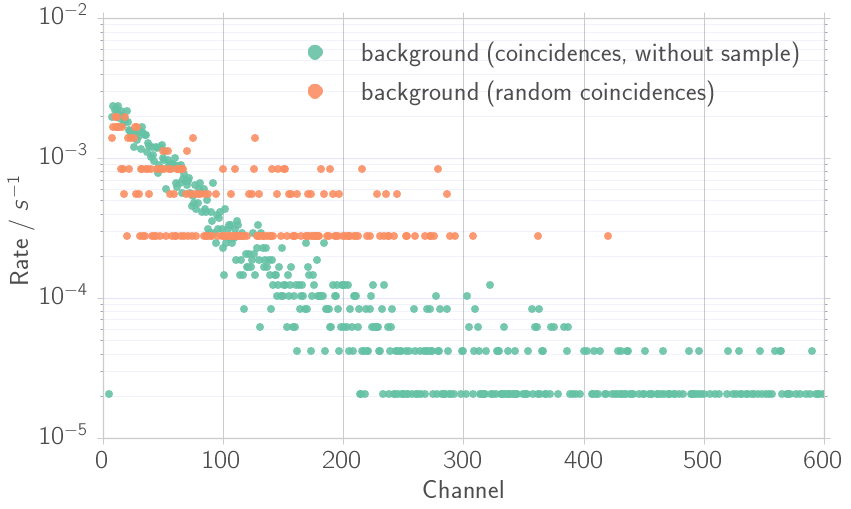

In [454]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Histogram PS, coincident")
ax1.plot(x_bg, rate_bg, '.', alpha=0.9, label='background (coincidences, without sample)',markersize = 15)
ax1.plot(x_rnd, rate_rnd, '.', alpha=0.9, label='background (random coincidences)',markersize = 15)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 600)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1,markerscale = 2)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)


if show_fig:
    fig1.show()
if save_fig:
    file_name = "coin_background_random"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


## Random coincidences

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


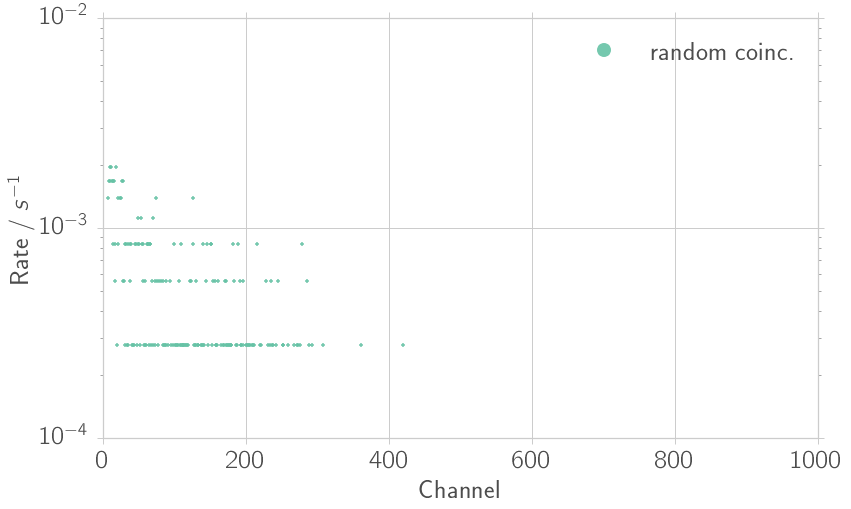

In [71]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Histogram PS, coincident")
ax1.plot(x_rnd, y_rnd, '.', alpha=0.9, label='random coinc.')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


# Rebinning might have to be redone - fits dont converge and errors might not be propagated correctly!

In [451]:
# %load fit_n_plot_ps.py
def fit_n_plot_ps(theta, fit_boundaries, p0, fit=True):
    save_fig=False
    '''
    Fits coincident electrons from PVC scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    rate_bg, rate_rnd, show_fig, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_ps_" + str(theta)
    file_in = npy_dir + file_name + '.npy'
    x, y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.mcd'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[5].split()[1]) # livetime is written in line 5...
    print(t/3600)
    rate = y / t
    rate = rate - rate_bg
    rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!
    rate_e = y_e / t - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = un.std_devs(rate_e[mask])
    if fit:
        coeff, cov = curve_fit(gauss, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)
        fit_peak = gauss(x_fit, *coeff)
        #x_c = coeff[1]
        c = uc.correlated_values(coeff, cov)
    else:
        fit_peak = gauss(x_fit, *p0)      # visualize initial guess
        c = 0

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        if not save_fig:
            fig1.suptitle("PVC scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(x, y, '.', alpha=0.9, label='Data')
        fixticks(ax1)
        peak, = ax1.plot(x_fit, fit_peak, '-', alpha=0.8, label='Fitted peak')
        #ax1.plot([x_c] * 2, [0, max(y)*1.5], '--', c=peak.get_color(), label='peak')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 400)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)

0.5
0.5
1.0
1.0
1.0
1.0
1.0176844444444446


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


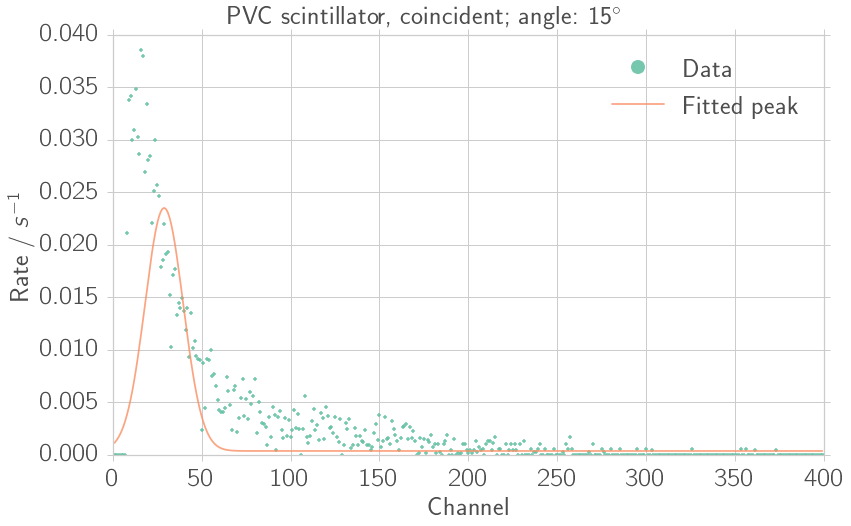

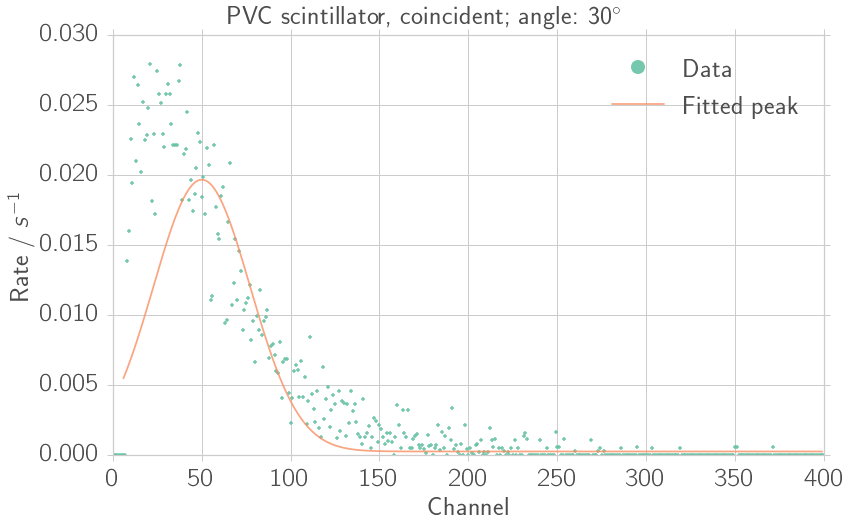

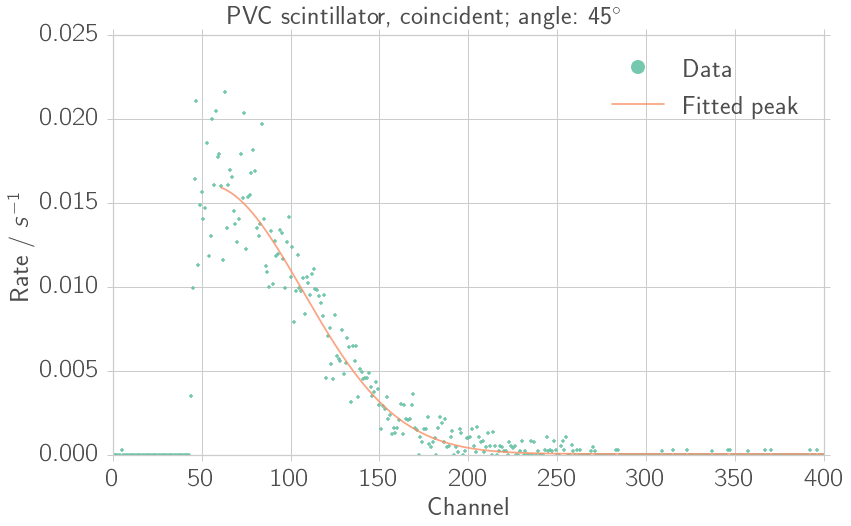

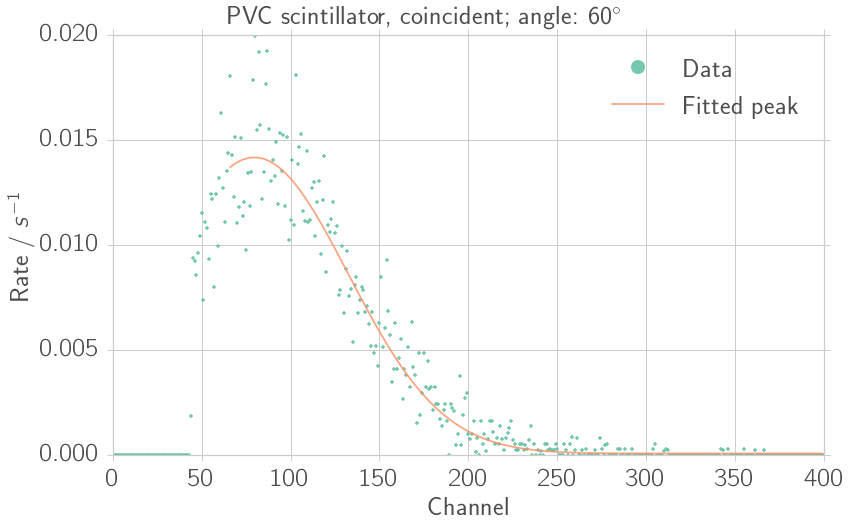

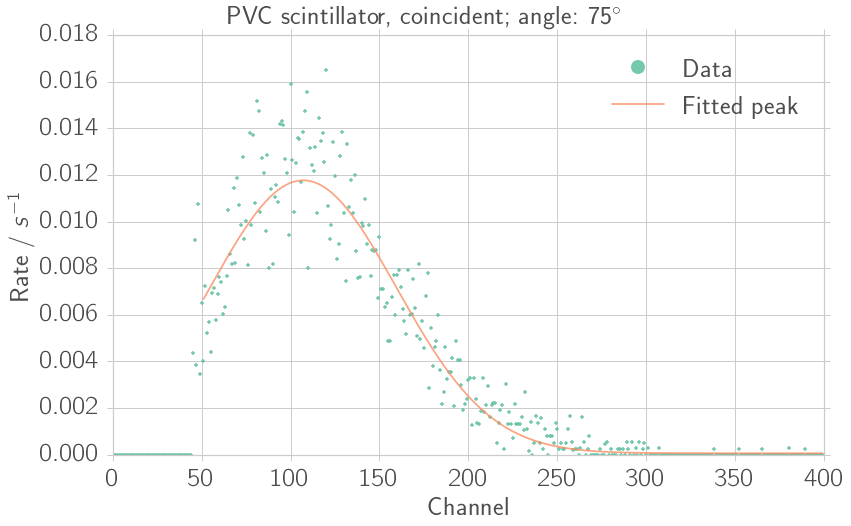

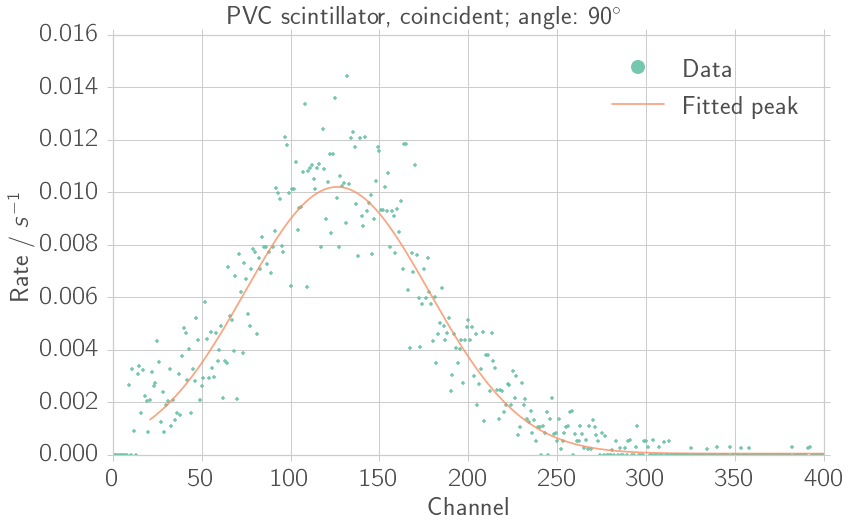

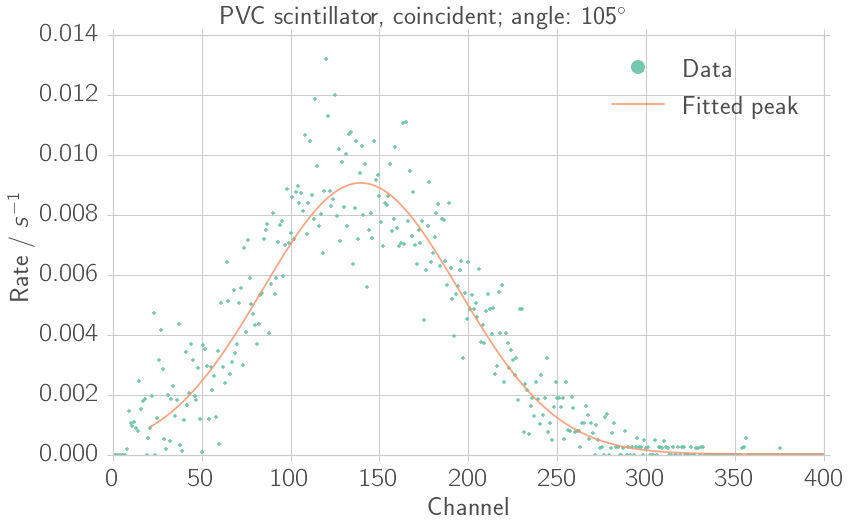

In [452]:
c_ps_gauss = []
theta_ps = [15, 30, 45, 60, 75, 90, 105]
fit_boundaries = [[0, 400],[5, 400], [60, 500], 
                  [65, 400],[50, 400], [20, 500], 
                  [20, 500]]
p0 = [[1.5e-2, 5, 40, 0],
      [2e-2, 44, 60, 0], 
      [0.01, 80, 40, 0],
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0]]

show_fig = True

for params in zip(theta_ps, fit_boundaries, p0):
    #if i[0] == 45:
    #    c = (fit_n_plot_ps(*i, fit=True))
    #    print(c)  
    c_ps_gauss.append(fit_n_plot_ps(*params, fit=True))
show_fig = True

In [447]:
# %load fit_n_plot_ps.py
def filter_n_plot_ps(theta, fit_boundaries, p0, fit=True):
    save_fig = False

    #### GET DATA  ####
    file_name = "coin_ps_" + str(theta)
    file_in = npy_dir + file_name + '.npy'
    x, y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.mcd'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[5].split()[1]) # livetime is written in line 5...
    print(t/3600)
    rate = y / t
    rate = rate - rate_bg
    rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!
    rate_e = y_e / t - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 
    y_filtered2 = sav(y[10::], 81, 4)
    
    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            fig1.suptitle("PVC scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(x, y, '.', alpha=0.9, label='Data')
        ax1.plot(x[10::], y_filtered2, '-', alpha=0.9, label='Filtered data')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(10, 400)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name +"_filter_"+ ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")
    channels = x[10::]
    max_channel = np.argmax(y_filtered2)
    val_at_std = np.max(y_filtered2)*0.9
    max_channel_std = np.max(np.abs(((channels - max_channel)[val_at_std < y_filtered2])))
    chu = uc.ufloat(max_channel,max_channel_std+1)
    return(chu)

0.5
0.5


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


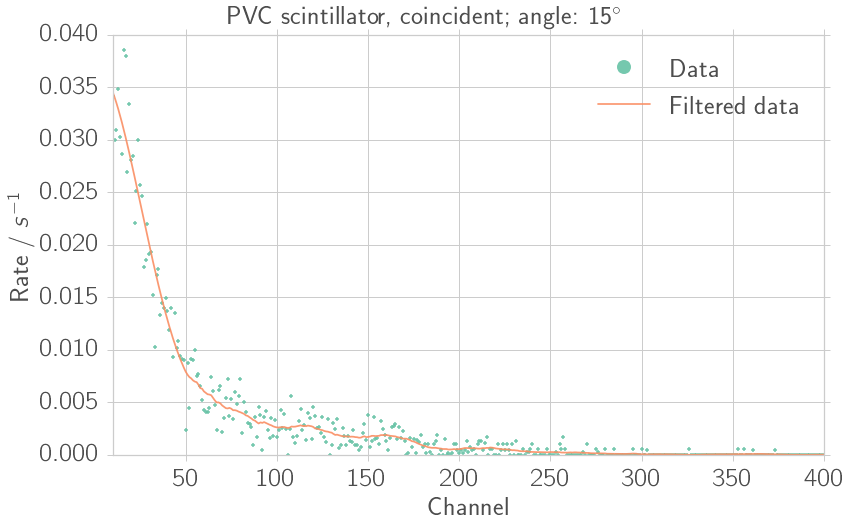

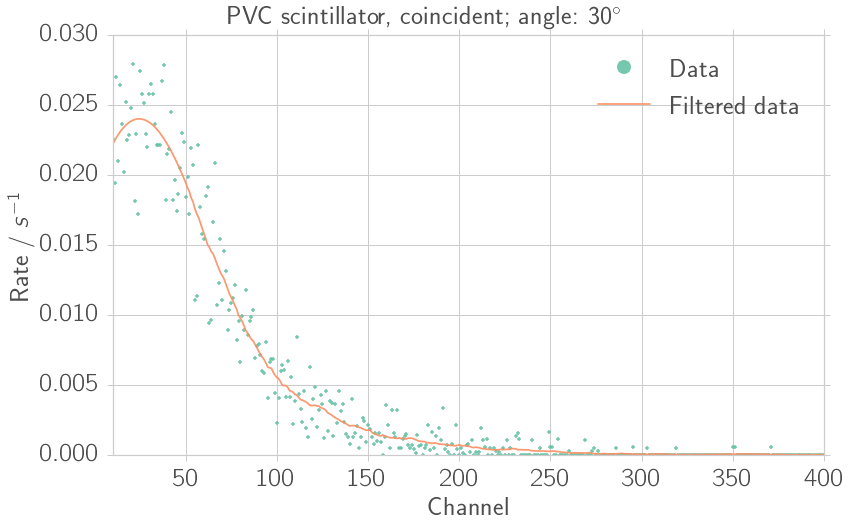

In [449]:
show_fig = True
c_ps_filter = []
for i in zip(theta_ps, fit_boundaries, p0):
    c_ps_filter += [(0,filter_n_plot_ps(*i))]

#NaI (photons)

## $^{137}$Cs Sample at various angles, NaI (photons)

Background data not measured... Random coincidences need to be added.

In [43]:
'''
#### Background ####
file_name = "filename"
file_in = npy_dir + "coin_na_background" + '.npy'
x_bg, y_bg = np.load(file_in)
t = 56708.322 
rate_bg = y_bg / t
y_bg = rate_bg
'''

'\n#### Background ####\nfile_name = "filename"\nfile_in = npy_dir + "coin_na_background" + \'.npy\'\nx_bg, y_bg = np.load(file_in)\nt = 56708.322 \nrate_bg = y_bg / t\ny_bg = rate_bg\n'

In [44]:
'''
# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram NaI, coincident")
ax1.plot(x_bg, y_bg, '-', alpha=0.9, label='background')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")
'''

'\n# Plotting\nfig1, ax1 = plt.subplots(1, 1)\nif not save_fig:\n    fig1.suptitle("Histogram NaI, coincident")\nax1.plot(x_bg, y_bg, \'-\', alpha=0.9, label=\'background\')\nax1.set_xlabel("Channel")\nax1.set_ylabel("Rate / $s^{-1}$")\nax1.set_xlim(0, 1000)\n#ax1.set_ylim(0, 0.025)\nax1.legend(loc=1)\nax1.grid(True)\n#ax1.set_yscale("log", nonposy=\'clip\')\nif show_fig:\n    fig1.show()\nif save_fig:\n    fig1.savefig(fig_dir + file_name + ".pdf")\n    fig1.savefig(fig_dir + file_name + ".png")\n'

In [148]:
# %load fit_n_plot_na.py
def fit_n_plot_na(theta, fit_boundaries, p0, fit=True):
    '''
    Fits coincident photons from NaI scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    rate_bg, rate_rnd, show_fig, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_na_" + str(theta)
    file_in = npy_dir + "coin_na_" + str(theta) + '.npy'
    y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.TKA'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[1]) # livetime is written in line 1...

    rate = y / t
    #rate = rate - rate_bg
    #rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!

    rate_e = y_e / t # - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 


    # Rebinning: 1/16 of number of bins
    z = y[:-14] # last 14 bins are dropped to obtain a len(z) as a multiple of 16
    z = z.reshape([len(z) / 16, 16])
    z = np.sum(z, axis=1)
    y = z

    z_e = rate_e[:-14] # last 14 bins are dropped to obtain a len(z) as a multiple of 16
    z_e = z_e.reshape([len(z_e) / 16, 16])
    z_e = np.sum(z_e, axis=1)
    y_e = z_e
    np.save(npy_dir + 'na_rate_' + str(theta), y_e)

    x = np.arange(len(y))
    y_filtered = sav(y, 201, 7)

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    if fit:
        coeff, cov = curve_fit(gauss0, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)
        fit_peak = gauss0(x_fit, *coeff)
        #x_c = coeff[1]
        c = uc.correlated_values(coeff, cov)
        np.save(npy_dir + 'i_photon_' + str(theta), c[0])
    else:
        fit_peak = gauss0(x_fit, *p0)      # visualize initial guess
        c = 0

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            fig1.suptitle("NaI scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(x, y, '.', alpha=0.9, label='data')
        peak, = ax1.plot(x_fit, fit_peak, '-', alpha=0.8, label='peak fit')
        #ax1.plot([x_c] * 2, [0, max(y)*1.5], '--', c=peak.get_color(), label='peak')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 800)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        savefig = False
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


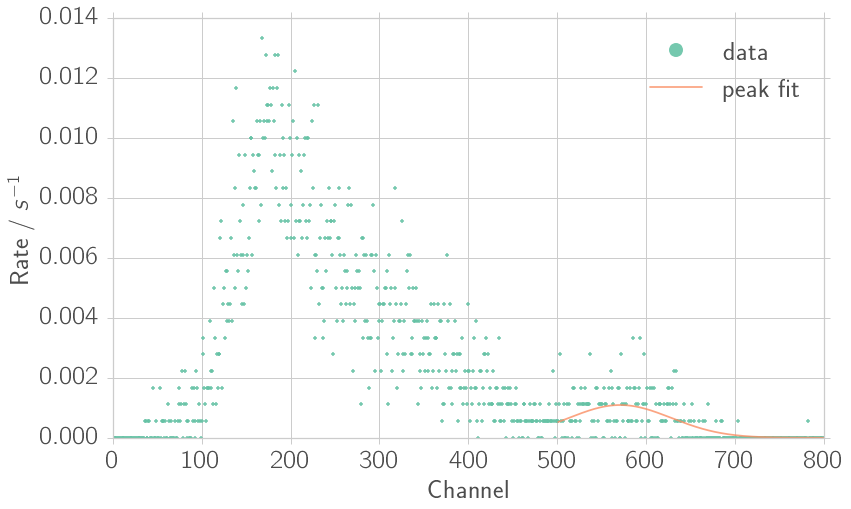

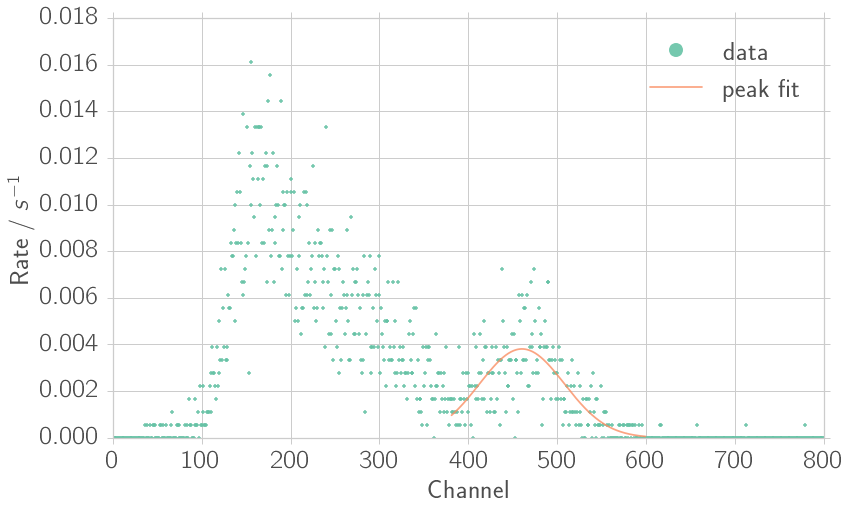

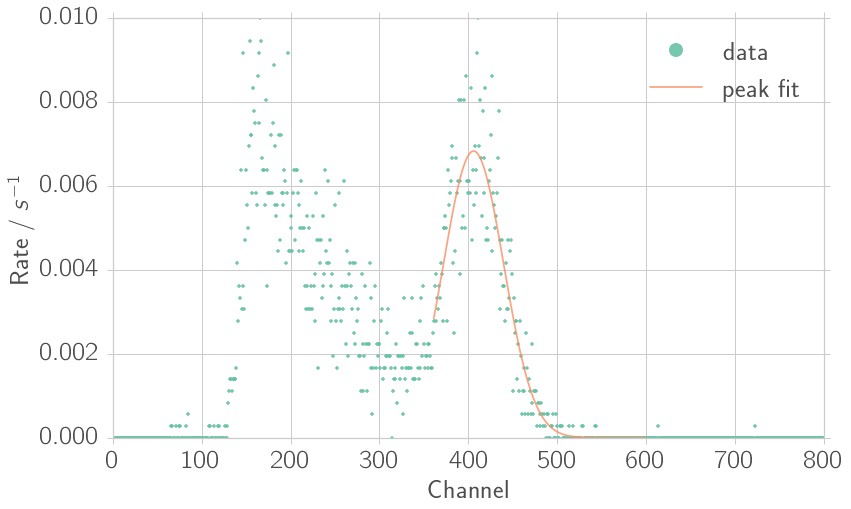

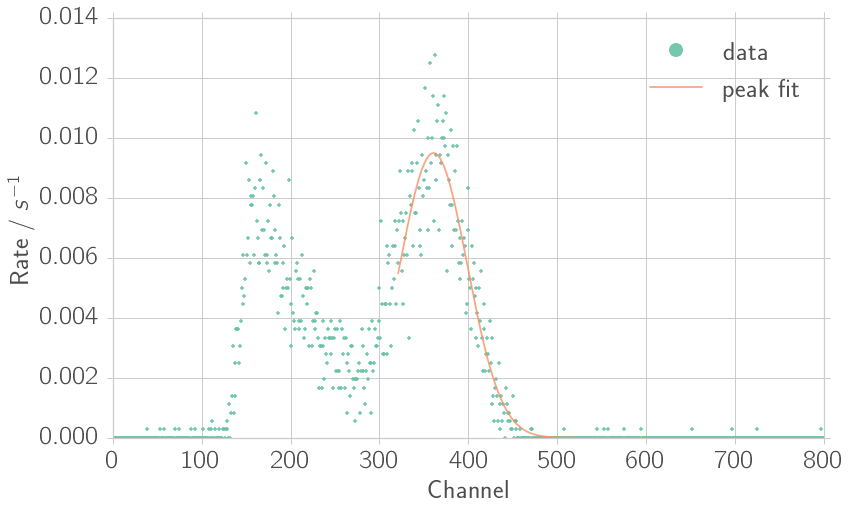

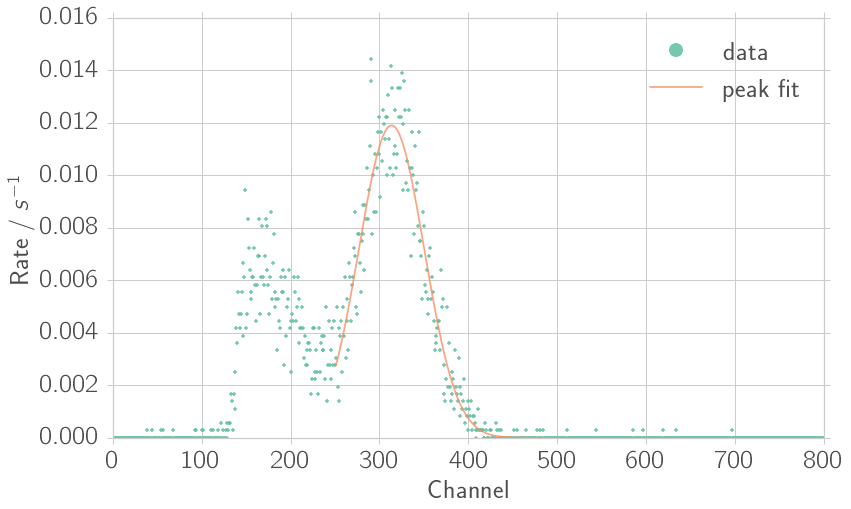

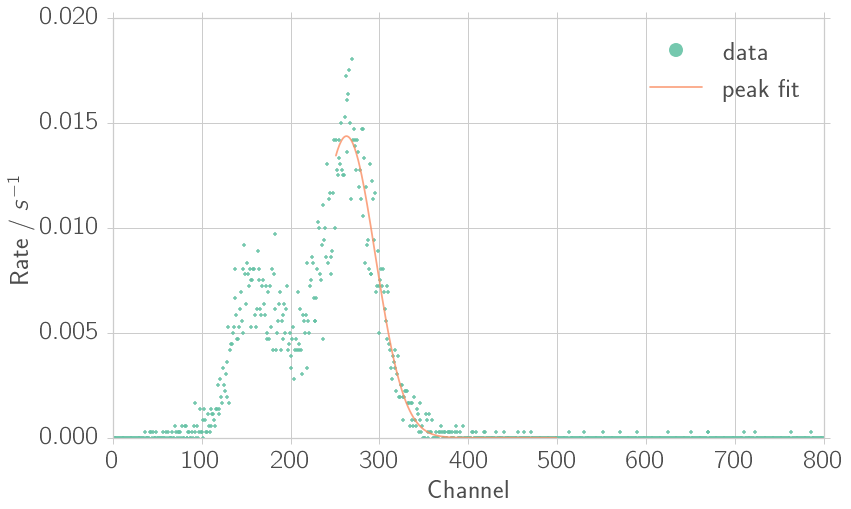

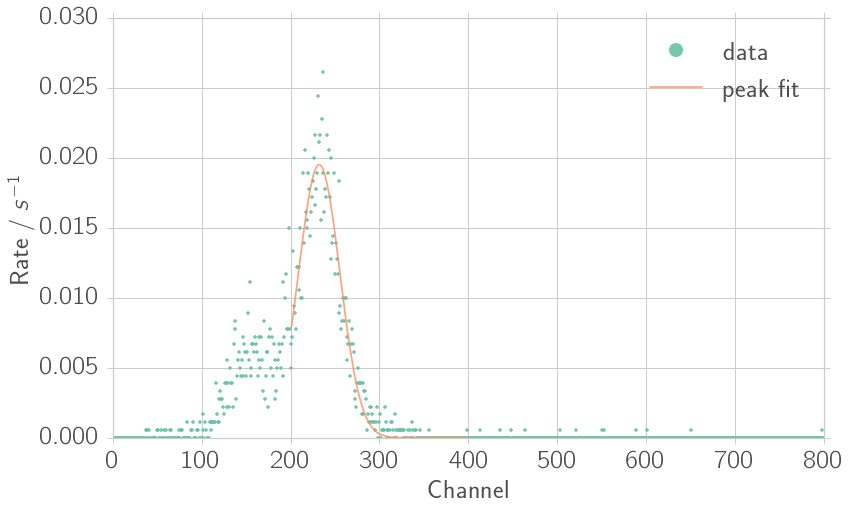

In [397]:
c_na = []
theta_na = [15, 30, 45, 60, 75, 90, 105]
fit_boundaries = [[500, 800], [380, 600], 
                  [360, 600], [320, 600], [250, 500],
                  [250, 500], [200, 400]]
p0 = [[2e-3, 600, 40, 0],
      [4e-3, 480, 40, 0],
      [1e-2, 400, 40, 0], 
      [1.2e-2, 370, 30, 0], 
      [1.4e-2, 320, 30, 0],
      [1.6e-2, 280, 30, 0],
      [1e-2, 220, 30, 0]]

p0 = [[0.2, 600, 40],
      [0.5, 480, 40],
      [0.6, 400, 40], 
      [0.9, 370, 30], 
      [1.1, 320, 30],
      [1.2, 280, 30],
      [1.1, 220, 30]]

show_fig = True
for i in zip(theta_na,fit_boundaries, p0):
    #if i[0] == 90:
    c_na.append(fit_n_plot_na(*i, fit=True))
show_fig = True

In [47]:
[c[0] for c in c_na]

[0.15812268752995892+/-1.0732979792919015,
 0.45613287111100775+/-0.8135883983854895,
 0.5788923582952565+/-0.5614349844517301,
 0.903694095803321+/-0.7325939035576006,
 1.0916958578149405+/-0.5542863898842432,
 1.167543023624683+/-1.7051238354625744,
 1.1354881045453435+/-0.6744055177398348]

# Plot energy conservation

## Channel to energy

['900 \\pm 600', '680 \\pm 20', '730 \\pm 90']


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


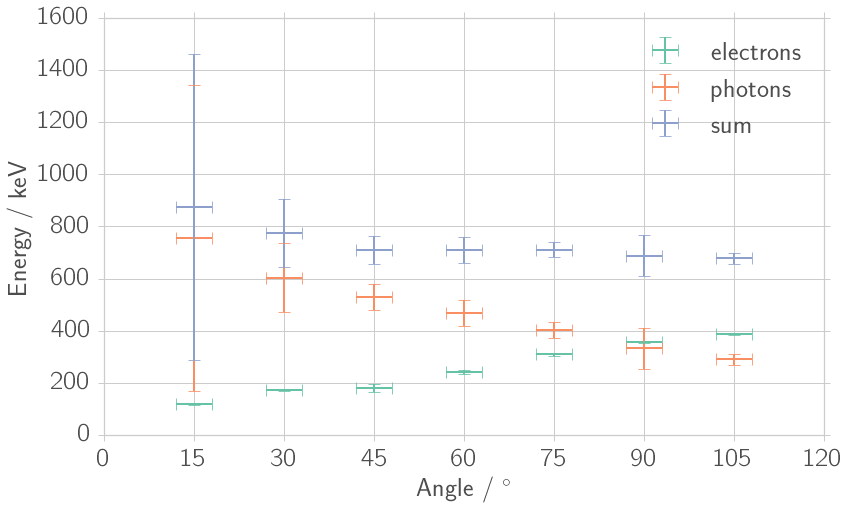

In [395]:
ps_cal = np.load(npy_dir + 'ps_calibration.npy')
na_cal = np.load(npy_dir + 'na_calibration.npy')

ucarray = lambda X: un.uarray([i.n for i in X],[i.s for i in X])

E_peaks_ps = ucarray([linear(ci[1], *ps_cal) for ci in c_ps_gauss])
E_peaks_na = ucarray([linear(16 * ci[1], *na_cal) for ci in c_na])
theta = theta_na
E_sum = E_peaks_ps + E_peaks_na
print(list(map(uc_str,[E_sum.max(),E_sum.min(),E_sum.mean()])))
angle_error = 3

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle('Energy conservation, all angles')
ax1.errorbar(theta_ps, un.nominal_values(E_peaks_ps), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_ps), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='electrons')
ax1.errorbar(theta_na, un.nominal_values(E_peaks_na), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_na), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='photons')
ax1.errorbar(theta, un.nominal_values(E_sum), \
             xerr=angle_error, yerr=un.std_devs(E_sum), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='sum')
ax1.set_xlim(0, 120)
ax1.set_ylim(0,)
ax1.set_xlabel("Angle / $^\circ$")
ax1.set_ylabel("Energy / keV")
ax1.legend(loc=1)
ax1.set_xticks(np.arange(0, 121, 15))
ax1.grid(True)
if save_fig:
    file_name = "energy_conservation"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


##II: This time we do not use the first four figures for fitting, instead we estimate their maximum by filtering.

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


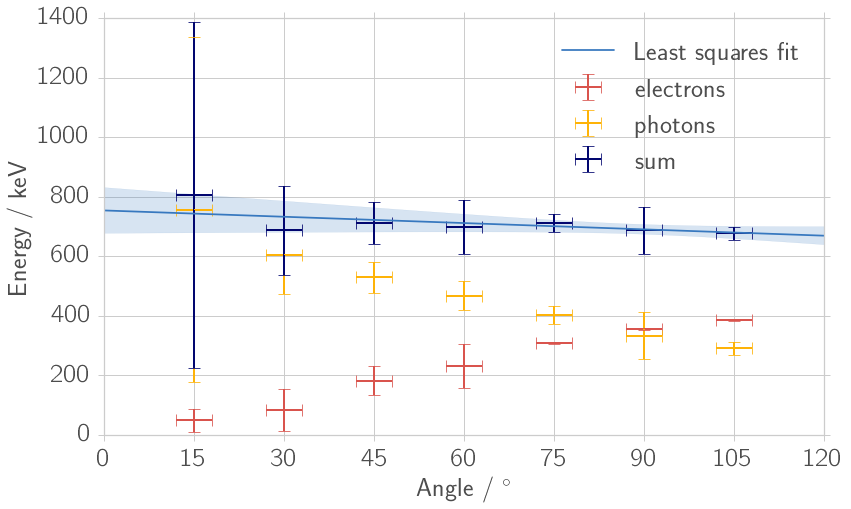

In [442]:
def height(channel, a,b):
    return a + b*channel

ps_cal = np.load(npy_dir + 'ps_calibration.npy')
na_cal = np.load(npy_dir + 'na_calibration.npy')

c_ps = np.array([i[1] for i in c_ps_filter[0:4]]+[i[1] for i in c_ps_gauss[4::]])

E_peaks_ps = ucarray([linear(ci, *ps_cal) for ci in c_ps])
E_peaks_na = ucarray([linear(16 * ci[1], *na_cal) for ci in c_na])
theta = theta_na
E_sum = E_peaks_ps + E_peaks_na


angle_error = 3

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle('Energy conservation, all angles')
ax1.errorbar(theta_ps, un.nominal_values(E_peaks_ps), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_ps), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='electrons',color=colors[1])
ax1.errorbar(theta_na, un.nominal_values(E_peaks_na), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_na), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='photons',color=colors[3])
ax1.errorbar(theta, un.nominal_values(E_sum), \
             xerr=angle_error, yerr=un.std_devs(E_sum), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='sum',color=colors[8])


p0 = [700,0]

coeff, cov = curve_fit(height,theta, nom(E_sum), p0=p0,
                sigma=sam(E_sum), absolute_sigma=True)

coeff = uc.correlated_values(coeff, cov)
theta_fit = np.linspace(0,120)
fit = height(theta_fit,*coeff)

ax1.plot(theta_fit,nom(fit),color=colors[0],label="Least squares fit")

ax1.fill_between(theta_fit, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)


ax1.set_xlim(0, 120)
ax1.set_ylim(0,)
ax1.set_xlabel("Angle / $^\circ$")
ax1.set_ylabel("Energy / keV")
ax1.legend(loc=1)
ax1.set_xticks(np.arange(0, 121, 15))
ax1.grid(True)
if save_fig:
    file_name = "energy_conservation"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


In [445]:
[uc_str(k) for k in coeff]

['750 \\pm 80', '-0.7 \\pm 0.8']

734.5495129835319+/-87.29038397191147